<a href="https://colab.research.google.com/github/Baduisef/R_Code-/blob/main/Makalou_diabete_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importation des library

In [ ]:
install.packages("tidymodels")
install.packages("e1071")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘Rcpp’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




In [ ]:
install.packages("ROSE")
install.packages("skimr")
install.packages("GGally")
install.packages("corrplot")
install.packages("broom")
install.packages("pROC")
install.packages("yardstick")

In [ ]:
library(tidyverse, quietly=TRUE)
#library(tidymodels)
#library(e1071)
#library(ROSE)
library(skimr)
library(GGally)
library(corrplot)
library(broom)
library(pROC)
library(yardstick)

Chargement de la data

In [ ]:
df <- read.csv('/content/DATABASE_INTOX_DM.csv',header = T, sep = ';')

ERROR: ignored

In [ ]:
df<-df %>%
  rename(Grossesses=Pregnancies ,Resultats=Outcome ,Fonction_pedigre_diabetes=DiabetesPedigreeFunction ,
  Insuline=Insulin, Epaisseur_peau=SkinThickness ,Tension_arterielle=BloodPressure) %>%
  mutate(Resultats=as_factor(Resultats))


In [ ]:
log10(1)

[1] 0

In [ ]:
df%>%
  head()

                                              
1 function (x, df1, df2, ncp, log = FALSE)    
2 {                                           
3     if (missing(ncp))                       
4         .Call(C_df, x, df1, df2, log)       
5     else .Call(C_dnf, x, df1, df2, ncp, log)
6 }                                           

In [ ]:
df %>%
  skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             768       
Number of columns          9         
_______________________              
Column type frequency:               
  factor                   1         
  numeric                  8         
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts    
1 Resultats             0             1 FALSE          2 0: 500, 1: 268

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable             n_missing complete_rate    mean      sd     p0
1 Grossesses                        0             1   3.85    3.37   0    
2 Glucose                           0             1 121.     32.0    0    
3 Tension_arterielle                0         

ERROR: ignored

In [ ]:
# Etiquetter la variable "Resultats : 1= Positif; 0= Negatif"
df <- df %>%
  mutate(res=ifelse(Resultats == 1, "Positif" ,"Negatif"))%>%
  mutate(res= as_factor(res))


In [ ]:
df %>%
  count(res)%>%
  mutate(proportion=n/sum(n))

res,n,proportion
<fct>,<int>,<dbl>
Positif,268,0.3489583
Negatif,500,0.6510417


les resultats des tests montrent que 35% des patients vivent avec le diabéte de type 2





VISUALISATION DES *DONNEES*

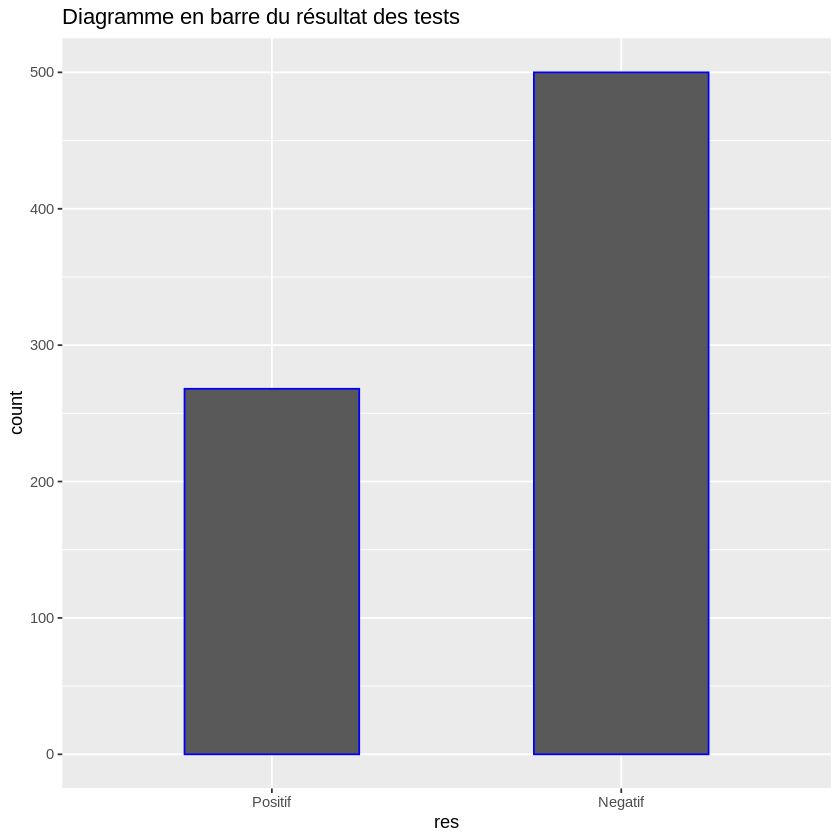

In [ ]:
df%>%
  ggplot(aes(res))+
  geom_bar(width = 0.5, color= 'blue')+
  labs(title="Diagramme en barre du résultat des tests")+
  theme_gray()


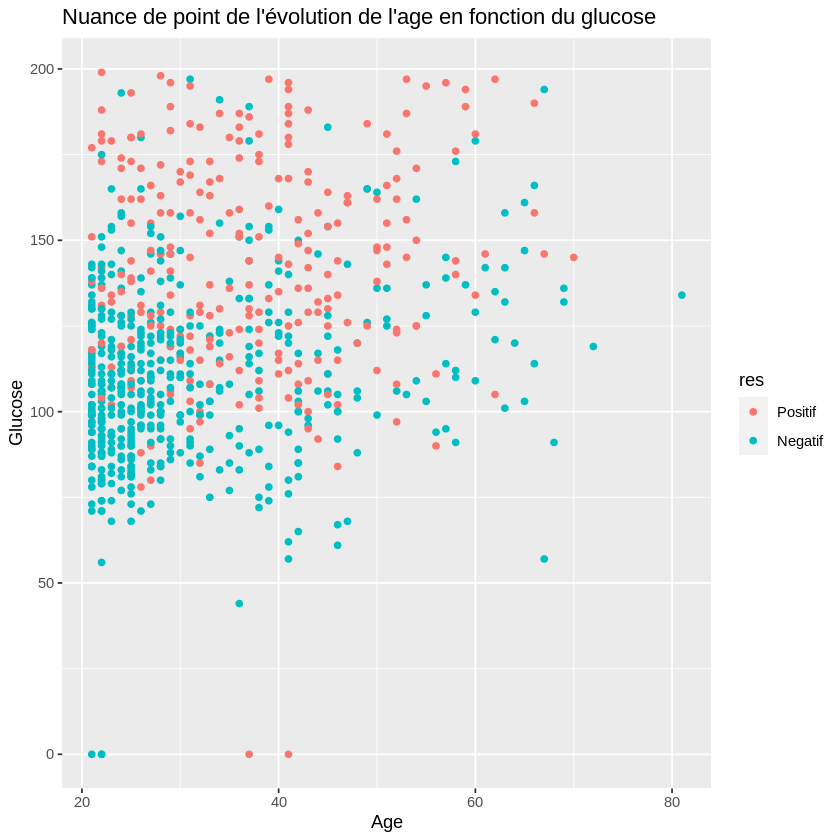

In [ ]:
df%>%
  ggplot(aes(x=Age, y=Glucose, color=res))+
  geom_point()+
  labs(title="Nuance de point de l'évolution de l'age en fonction du glucose")+
  theme_gray()


Le nuance de point montre claire que notre échantillon présente plus de tests négatifs que positifs. Ce qui confirme le digramme en barre précédent.


Nous devons allons équilibrer les classes qui d'estimer notre modèle pour ne pas avoir des estimations biaisées.

Statisques bivariées

In [ ]:
df_work <- df%>%
  select(-Resultats)

head(df_work)

,Grossesses,Glucose,Tension_arterielle,Epaisseur_peau,Insuline,BMI,Fonction_pedigre_diabetes,Age,res
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<fct>
1,6,148,72,35,0,33.6,0.627,50,Positif
2,1,85,66,29,0,26.6,0.351,31,Negatif
3,8,183,64,0,0,23.3,0.672,32,Positif
4,1,89,66,23,94,28.1,0.167,21,Negatif
5,0,137,40,35,168,43.1,2.288,33,Positif
6,5,116,74,0,0,25.6,0.201,30,Negatif


Croisons les autres variables des notre base au résultat du test


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


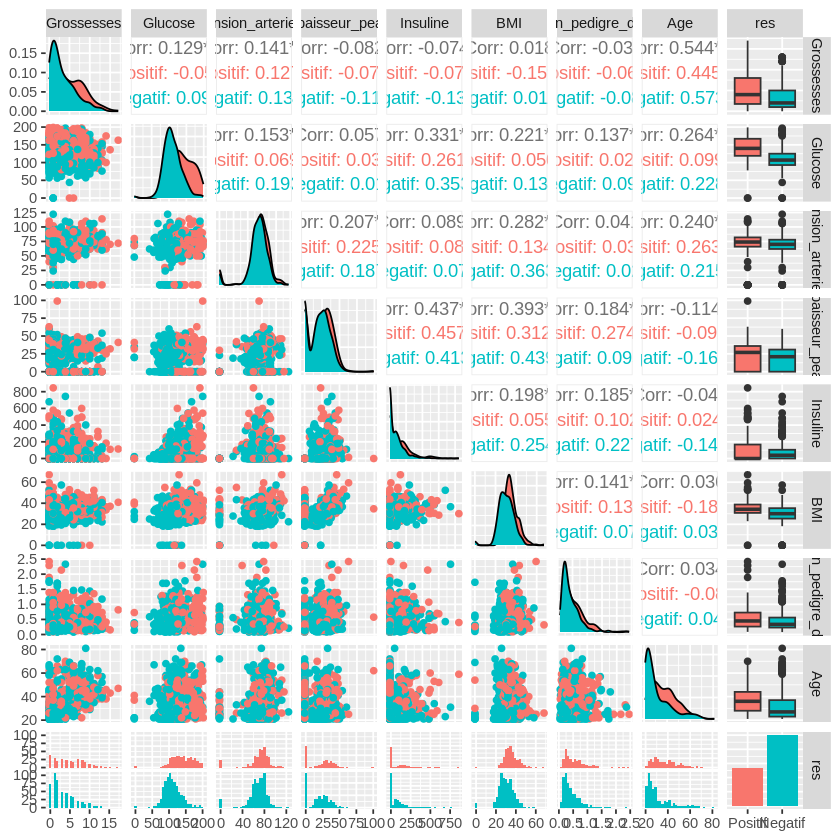

In [ ]:
df_work%>%
  ggpairs(mapping = aes(color=res))

Interprétation: Il semble avoir absence de relation entre les variables explicatives à l'exception du glucose et de l'insuline. En effet, le nuance de point entre le taux de glucose et de l'insuline semble etre linéaire.

Les boites à moustaches différentient bien les diabétiques de type 2 aux non diabétiques de type 2 selon leur caractéristique

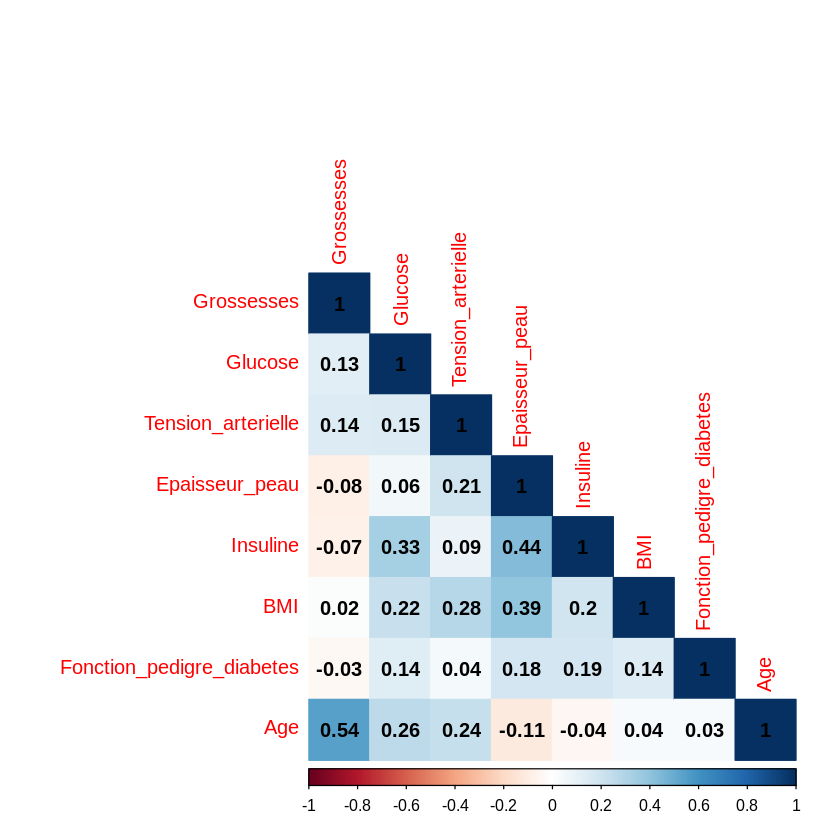

In [ ]:
# Matrice de corrélation
df_work_cor <- df_work %>%
  select(-res)%>%
  cor()%>%
  corrplot(method = "color", type = "lower", addCoef.col = "black")

Interprétation:
En réalité, il y a corrélation qu'entre l'age des patients et le nombre de grosseses.

PREPARATION à la modélisation: division de la base de données en données d'apprentissage et données de test.

Les données d'apprentissage nous permettent d'entrainer notre modèle (estimation des paramétres) et les données de test servent à évaluer à capacité prédictive du modèle.

In [ ]:
df_modling <- recipe(res ~.,data = df_work)%>%
  step_dummy(all_nominal(),-all_outcomes())%>%
  step_zv()%>%
  step_normalize(all_numeric())%>%
  prep()

In [ ]:
work_modling<-juice(df_modling)
head(work_modling)

Grossesses,Glucose,Tension_arterielle,Epaisseur_peau,Insuline,BMI,Fonction_pedigre_diabetes,Age,res
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.6395305,0.8477713,0.1495433,0.9066791,-0.6924393,0.2038799,0.4681869,1.42506672,Positif
-0.8443348,-1.1226647,-0.1604412,0.5305558,-0.6924393,-0.6839762,-0.3648230,-0.19054773,Negatif
1.2330766,1.9424580,-0.2637694,-1.2873733,-0.6924393,-1.1025370,0.6040037,-0.10551539,Positif
-0.8443348,-0.9975577,-0.1604412,0.1544326,0.1232213,-0.4937213,-0.9201630,-1.04087112,Negatif
-1.1411079,0.5037269,-1.5037073,0.9066791,0.7653372,1.4088275,5.4813370,-0.02048305,Positif
0.3427574,-0.1530851,0.2528715,-1.2873733,-0.6924393,-0.8108128,-0.8175458,-0.27558007,Negatif


In [ ]:
set.seed(1234)
work_split <- initial_split(work_modling)
work_training <- training(work_split)
work_testing <- testing(work_split)


In [ ]:
work_testing%>%
  nrow()

work_training%>%
  nrow()

[1] 192

[1] 576

Pré préparation des données

In [ ]:
work_training <- ovun.sample(formula = res ~ .,
                             data = work_training,
                             method = "under")

work_training_df<-work_training$data

In [ ]:
work_training_df %>%
  count(res)%>%
  mutate(proportion=n/sum(n))

res,n,proportion
<fct>,<int>,<dbl>
Negatif,184,0.4880637
Positif,193,0.5119363


Estimons le modèle logistique maintenet


In [ ]:
#Spécification du modèle:
logistic_model <- logistic_reg() %>%
  set_engine("glm") %>%
  set_mode("classification") %>%
  fit(res ~ ., data = work_training_df)

#coef<-tidy(logistic_model)
coefs <- tidy(logistic_model, conf.int = TRUE, exp = TRUE, conf.level = 0.95)


print(coefs)



# A tibble: 9 × 7
  term                  estimate std.error statistic  p.value conf.low conf.high
  <chr>                    <dbl>     <dbl>     <dbl>    <dbl>    <dbl>     <dbl>
1 (Intercept)              0.819     0.134    -1.49  1.36e- 1    0.628      1.06
2 Grossesses               1.41      0.165     2.08  3.72e- 2    1.02       1.96
3 Glucose                  3.08      0.167     6.76  1.39e-11    2.25       4.34
4 Tension_arterielle       0.831     0.148    -1.25  2.11e- 1    0.616      1.10
5 Epaisseur_peau           0.808     0.156    -1.37  1.72e- 1    0.596      1.10
6 Insuline                 0.916     0.147    -0.600 5.49e- 1    0.689      1.23
7 BMI                      2.30      0.177     4.72  2.35e- 6    1.66       3.32
8 Fonction_pedigre_dia…    1.81      0.159     3.73  1.93e- 4    1.34       2.49
9 Age                      1.40      0.157     2.13  3.30e- 2    1.03       1.92


Interprétation des Résultats:

Les resultats des estimations montrent que tout les coéfficients de notre modèles sont positifs.Cependant, seuls les coéfficients associés à la tension arterielle,l'épaisseur du peau et l'insuline ne sont pas significatifs au sieul de 5%.

On retient alors que le taux de glucose, le nombre de Grossesses, l'indice de masse corporel et la fonction pédigrée impactent positivement la probabilité de survenue du diabète de type 2.







In [ ]:
# Evaluation du modéle
# Predict outcome categories
class_preds <- predict(logistic_model, new_data = work_testing,
                       type = 'class')

# Obtain estimated probabilities for each outcome value
prob_preds <- predict(logistic_model, new_data = work_testing,
                      type = 'prob')

# Combine test set results
prediction_results <- work_testing %>%
  select(res) %>%
  bind_cols(class_preds, prob_preds)

# View results tibble
prediction_results %>%
    head()

res,.pred_class,.pred_Negatif,.pred_Positif
<fct>,<fct>,<dbl>,<dbl>
Positif,Positif,0.01203324,0.98796676
Negatif,Negatif,0.77202760,0.22797240
Positif,Negatif,0.92309478,0.07690522
Negatif,Positif,0.30057054,0.69942946
Positif,Positif,0.19010004,0.80989996
Positif,Positif,0.46022325,0.53977675


In [ ]:
 prediction_results$.pred_class <- relevel(prediction_results$.pred_class, "Positif")
table(prediction_results$.pred_class)


Positif Negatif 
     91     101 

In [ ]:
# Calculate the confusion matrix
matrix_conf<- conf_mat(data = prediction_results,
 truth = res,
 estimate = .pred_class
 )

matrix_conf

          Truth
Prediction Positif Negatif
   Positif      60      31
   Negatif      15      86